# Out of sample prediction


# Package


In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

from statsmodels.tsa.arima_model import ARMA
from matplotlib import pyplot as plt
%matplotlib inline

# Data

## Training data


In [2]:
def data_pro(table):
    df=pd.read_csv(table,header=0)
    N=len(df["SYM_ROOT"].unique())
    symbol=df["SYM_ROOT"].unique()
    volume=[[] for _ in range(N)]
    price=[[] for _ in range(N)]
    k=0
    for s in symbol:
        df_t=df[df['SYM_ROOT']==s]
        Pt=[]
        St=[]
        T=[]
        i=-1
        for j in range(len(df_t['TIME_M'])):
            if np.array(df_t['TIME_M'])[j][:-13] not in T:
                i+=1
                T.append(np.array(df_t['TIME_M'])[j][:-13])
                Pt.append(np.array(df_t['PRICE'])[j])
                St.append(np.array(df_t['SIZE'])[j])
            else:
                St[i]+=np.array(df_t['SIZE'])[j]
        pt=[]
        st=[]
        tt=[]
        start=datetime.datetime.strptime("09:30", "%H:%M")
        j=0
        for i in range(390):
            tt.append(start)
            if j<len(T):
                if start==datetime.datetime.strptime(T[j],'%H:%M'):
                    pt.append(Pt[j])
                    st.append(St[j])
                    j+=1
                else:
                    pt.append(pt[-1])
                    st.append(0)
            else:
                pt.append(pt[-1])
                st.append(0)
            start+=datetime.timedelta(0,60)
        volume[k]=st
        price[k]=pt
        k+=1
    vol = np.array(volume)
    p = np.array(price)
    p = p.T
    table=pd.DataFrame(index=tt,columns=symbol)
    k=0
    for i in symbol:
        table[i]=vol[k]
        k+=1
    return table, p

In [5]:
table,p = data_pro("12.14_combined.csv")
table.tail()

,APC,FTI,HPQ,SANM,SIG,TEX,TIF,TJX
1900-01-01 15:55:00,51527,29636,200018,4507,38168,14738,21465,44594
1900-01-01 15:56:00,40711,22914,65744,1450,19504,14574,29500,34696
1900-01-01 15:57:00,48332,96951,63150,3362,7422,18132,30929,33600
1900-01-01 15:58:00,55154,71737,190187,1859,38282,23746,43500,45545
1900-01-01 15:59:00,114439,244806,367356,7854,35187,35773,78500,138954


## Test data

In [6]:
table2,p2 = data_pro("12.17_combined.csv")
table2.head()

,APC,FTI,HPQ,SANM,SIG,TEX,TIF,TJX
1900-01-01 09:30:00,32399,103952,523,8249,12885,10796,22377,243546
1900-01-01 09:31:00,7443,39323,187325,0,4383,1099,854,52281
1900-01-01 09:32:00,10155,50177,41019,201,5332,1320,309,25511
1900-01-01 09:33:00,3454,56074,22599,308,18296,1154,7853,26390
1900-01-01 09:34:00,6550,30511,11830,1115,1336,21020,10868,16840


# Data Standardlize


In [7]:
def data_stand(table):
    x = np.array(table[0:])
    scaler = StandardScaler().fit(x)
    x_std = scaler.transform(x)
    return scaler, x_std

In [8]:
scaler,pca_table=data_stand(table)
table2_std = scaler.transform(table2)

/Users/xia/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Volume Prediction

In [9]:
def cpa(x):
    pca=PCA()
    pca.fit(x)
    u = pca.components_
    lmb = pca.singular_values_
    C = np.dot(x, u)
    C = C.T
    x_mean = pca.mean_
    c = np.zeros(shape=(x.T).shape)
    y = np.zeros(shape=(x.T).shape)
    for i in range(x.shape[1]):
        c[i]=x_mean[i]+C[0]
        y[i]=x[:,i]-c[i]
    return c,y
c,y=cpa(pca_table)

In [10]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]

In [11]:
def diff(y):
    data = pd.Series(y)
    k=0
    while test_stationarity(data)>0.01:
        data = data.diff().dropna()
        k+=1
    diff = k
    return diff

In [12]:
def arima_model(c, y, diff):
    data = pd.Series(y)
    model = ARIMA(data, order=(2,diff,1))
    model_fit = model.fit(disp=-1)
    x_forecast_std = c + model_fit.forecast(steps = 1)[0].item()
    return x_forecast_std

In [13]:
# portfolio
forecast_std=np.zeros(shape=table2[0:30].shape)
for i in range(y.shape[0]):
    for j in range(30):
        z=y[i]
        data = pd.Series(z)
        k=0
        while test_stationarity(data)>0.01:
            data = data.diff().dropna()
            k+=1
        diff = k
        forecast_std[j][i]=arima_model(c[i][j],z,diff)
        y2=table2_std.T[i]-c[i]
        z=np.append(z,y2[j])
    
forecast=(scaler.inverse_transform(forecast_std)).T

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

In [14]:
forecast.shape

(8, 30)

# Volume Percentage Prediction

In [15]:
def percentage_forecast(x_forecast):
    max_ = x_forecast.max(axis=1)
    min_ = x_forecast.min(axis=1)
    for i in range(x_forecast.shape[0]):
        for j in range(x_forecast.shape[1]):
            x_forecast[i][j] = (x_forecast[i][j]-min_[i])/(max_[i]-min_[i])
    #         x_pre[i][j]=max(0,x_pre[i][j])
    x_forecast_sum = x_forecast.sum(axis=1)
    for i in range(x_forecast.shape[0]):
        for j in range(x_forecast.shape[1]):
            x_forecast[i][j] = x_forecast[i][j]/x_forecast_sum[i]
    return x_forecast
x_forecast=percentage_forecast(forecast)


In [16]:
df_xforecast=pd.DataFrame(columns=table.columns)
k=0
for i in table.columns:
    df_xforecast[i]=x_forecast[k]
    k+=1
df_xforecast.to_csv('df_xforecast_10.16.csv')

In [17]:
def percentage_true(table2):
    x = np.array(table2[0:30])
    x_sum = x.sum(axis=0)
    x_true=np.zeros(shape=x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x_true[i][j] = x[i][j]/x_sum[j]
    return x_true
x_true=percentage_true(table2)
x_true.shape


(30, 8)

# Plot

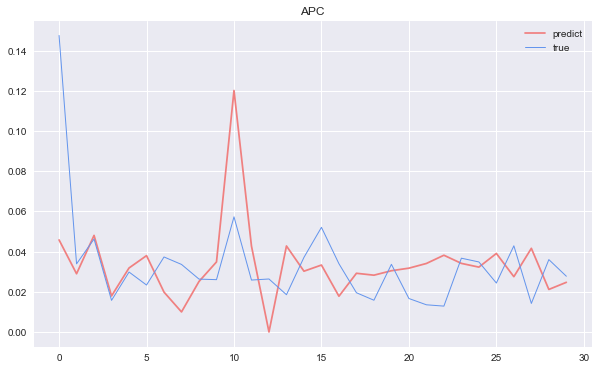

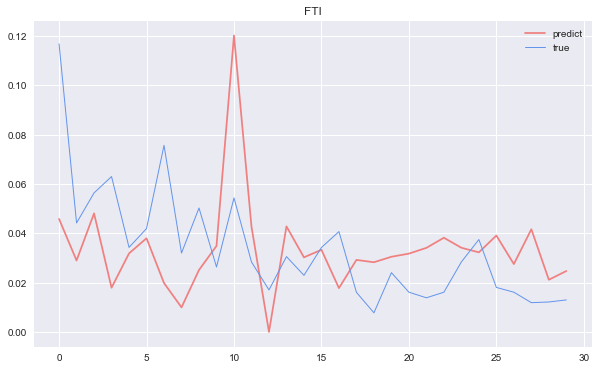

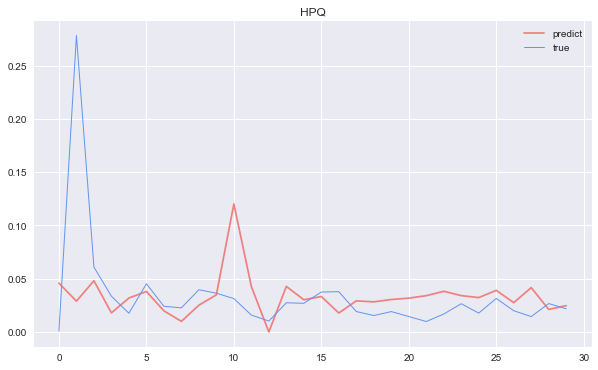

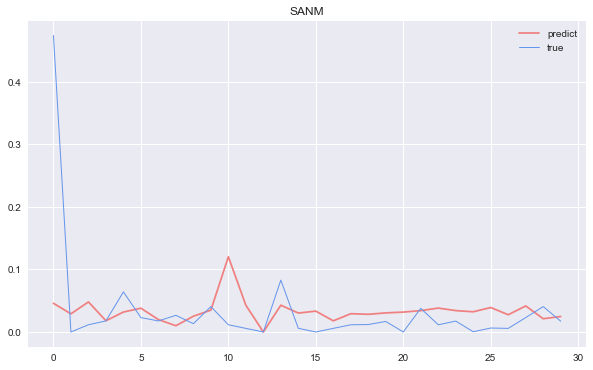

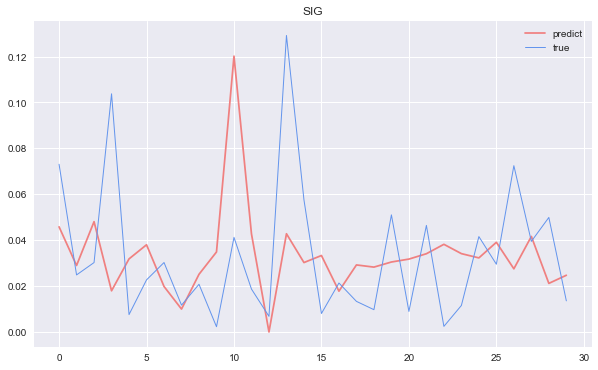

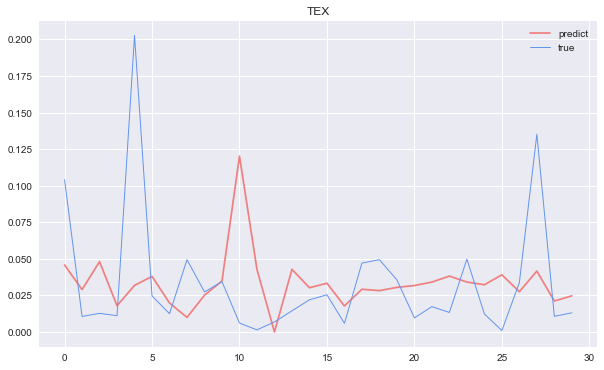

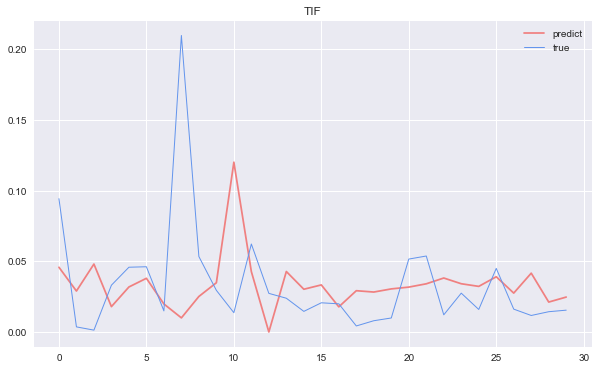

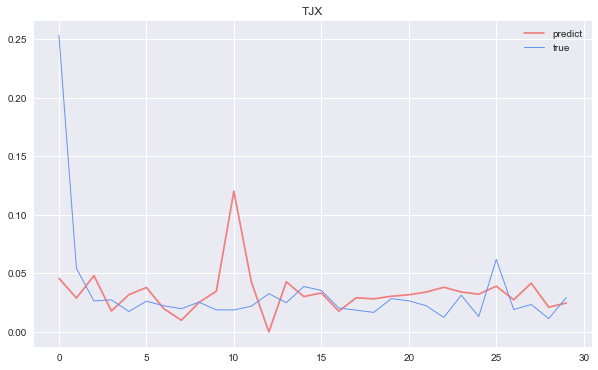

In [18]:
for i in range(y.shape[0]):
    plt.style.use('seaborn')
    plt.figure(figsize = (10,6),)
    plt.grid(True)
    plt.plot(x_forecast[i], color = 'lightcoral')
    plt.plot(x_true[:,i], color = 'cornflowerblue', linewidth = 1)
    plt.title(table.columns[i])
    plt.legend(['predict', 'true'])
    plt.savefig(table.columns[i] + "'.png")